# SANS reduction at RID

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from math import pi as pi
import re

## 1. File processing and basic plotting

In [6]:
from sansdata import *

Pixel size X: 0.0010526315789473684 m, Pixel size Y: 0.0005411255411255411 m
21
Sample: memb_BS_Q1_6_0Ang
275:750, 50:974
self.intensity shape: (924, 475)
lambda_0: 5.997383326898995
Pixel size X: 0.0010526315789473684 m, Pixel size Y: 0.0005411255411255411 m
21
Sample: glassyC_BS_Q4_6_0Ang


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


275:750, 50:974
self.intensity shape: (924, 475)
lambda_0: 5.996252696479434


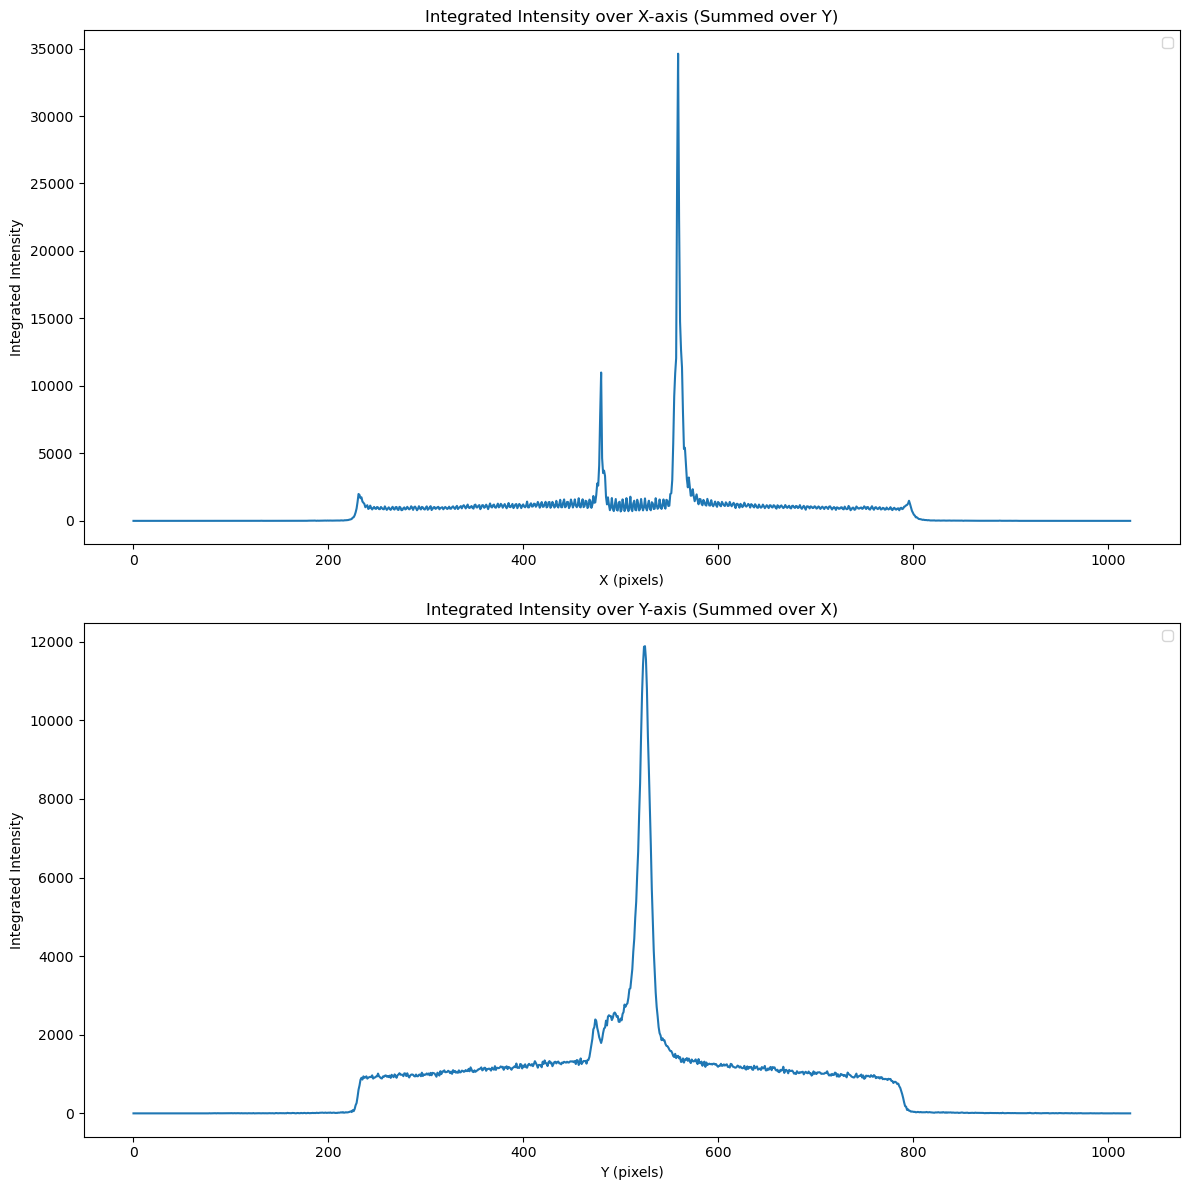

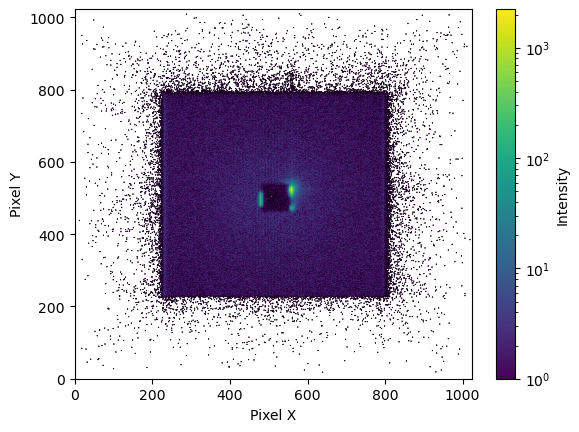

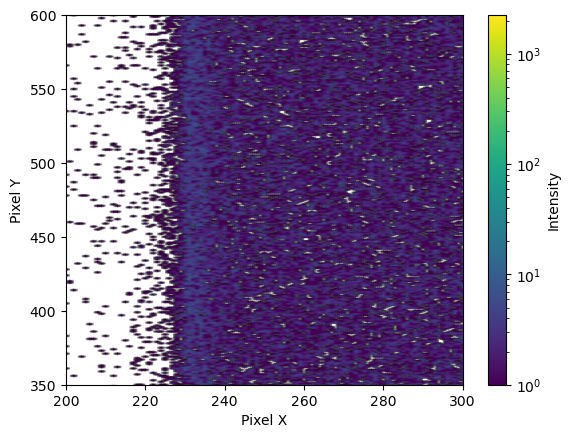

In [11]:
glassyC_sample = SansData('data/memb_BS_Q1_6_0Ang.mpa')
glassyC_sample = SansData('data/glassyC_BS_Q4_6_0Ang.mpa')
glassyC_sample.plot_integrated_intensity(axis=0, title='Integrated Intensity over X-axis')
glassyC_sample.plot_2d()

## 2. Automatic beam stop detection using OpenCV
The process is as follows:
- A threshold is applied to the image
- Contours are detected
- From these contours, a single minimum area rectangle is fitted

424
0


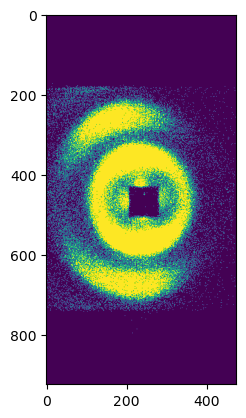

In [4]:
import cv2
# Convert Pillow Image to NumPy array
img_np = np.array(glassyC_sample.intensity)
print(img_np.max())
print(img_np.min())
img = (np.round(img_np / img_np.max() * 255)).astype(np.uint8)

ret, thresh = cv2.threshold(img, 1, 10, cv2.THRESH_BINARY)
plt.imshow(thresh)

In [ ]:
# Detects edges
from numpy import copy


edged = cv2.Canny(thresh, 2, 20, apertureSize=3, L2gradient=True)
plt.imshow(edged)

In [ ]:


# Find contours in the binary image
contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
edge_copy = copy(edged)
cv2.drawContours(edge_copy, contours, -1, (255, 255, 255), 3) 
plt.imshow(edge_copy)